In [1]:
import pandas as pd
import os
import math
import empyrical as empy
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


from sklearn.metrics import (
    precision_score, accuracy_score, confusion_matrix, 
    mean_squared_error, recall_score, f1_score
)
import warnings
warnings.filterwarnings("ignore")

In [2]:
def get_label(dfclose, pp=21):
    dfclose.index = pd.to_datetime(dfclose.index, format='%Y-%m-%d')
    y_pctch = -dfclose.pct_change(-pp).dropna(how='all')
    y_label = (y_pctch > 0).astype(int)
    return y_label, y_pctch


def get_records(file):
    df = pd.read_csv(file)
    df_pivot = pd.pivot_table(df, index='Train Date', columns='Symbol', values=['proba_1', 'Real Prediction'])
    df_pivot.index = pd.to_datetime(df_pivot.index)
    return df_pivot['proba_1'], df_pivot['Real Prediction']


def cal_metric_fromPred(y_pctch, y_pred):
    if isinstance(y_pred, pd.DataFrame):
        prec_ser = pd.Series(index=y_pred.columns, name='precision')
        acccc_ser = pd.Series(index=y_pred.columns, name='accuracy')
        recall_ser = pd.Series(index=y_pred.columns, name='recall')
        recall0_ser = pd.Series(index=y_pred.columns, name='recall0')
        f1_score_ser = pd.Series(index=y_pred.columns, name='f1_score')
        f0_score_ser = pd.Series(index=y_pred.columns, name='f0_score')
        for col in y_pred.columns:
            # print("   *********************************  ", col)
            prec_ser[col], acccc_ser[col], recall_ser[col], recall0_ser[col], f1_score_ser[col], f0_score_ser[col] = cal_metric_fromPred(
                y_pctch[col], y_pred[col])
        return prec_ser, acccc_ser, recall_ser, recall0_ser, f1_score_ser, f0_score_ser

    y_pred = y_pred.dropna()
    print(y_pred.name, y_pred.index[0], y_pred.index[-1])
    y_pctch = y_pctch.reindex(y_pred.index)
    # ydelta_true = y_pctch/y_pctch.std() + 0.5
    y_true = (y_pctch>=0).astype(int)
    # print("y_pctch\n", y_pctch)
    # print("ydelta_true\n", ydelta_true)
    # print("y_pred\n", y_pred)
    # print("y_true\n", y_true)
    # print("y_proba\n", y_proba)
    # pd.concat([y_proba, y_pred, y_pctch, y_true, ydelta_true], axis=1).to_csv("./tmp/{}.csv".format(y_pctch.name))
    
    try:
        prec = precision_score(y_true=y_true, y_pred=y_pred)
        acccc = accuracy_score(y_true=y_true, y_pred=y_pred)
    except Exception as e:
        print(e)
        prec = 0
        acccc = 0

    try:
        recall = recall_score(y_true=y_true, y_pred=y_pred)
        recall0 = recall_score(y_true=y_true, y_pred=y_pred, pos_label=0)
    except Exception as e:
        print(e)
        recall = 0
        recall0 = 0

    try:
        f1score = f1_score(y_true=y_true, y_pred=y_pred)
        f0score = f1_score(y_true=y_true, y_pred=y_pred, pos_label=0)
    except Exception as e:
        print(e)
        f1score = 0
        f0score = 0
    # print("mse, mse_proba, msefullscore, msefullscore_ret, prec, acccc, recall, recall0")
    # print(mse, mse_proba, msefullscore, msefullscore_ret, prec, acccc, recall, recall0)
    return prec, acccc, recall, recall0, f1score, f0score


def cal_metric(y_pctch, y_proba):

    if isinstance(y_proba, pd.DataFrame):
        mse_ser = pd.Series(index=y_proba.columns, name='MSE')
        mse_proba_ser = pd.Series(index=y_proba.columns, name='MSE_byProba')
        msefullscore_ser = pd.Series(index=y_proba.columns, name='MSE_fullscore')
        msefullscore_ret_ser = pd.Series(index=y_proba.columns, name='MSE_fullscore_byReturn')
        prec_ser = pd.Series(index=y_proba.columns, name='precision')
        acccc_ser = pd.Series(index=y_proba.columns, name='accuracy')
        recall_ser = pd.Series(index=y_proba.columns, name='recall')
        recall0_ser = pd.Series(index=y_proba.columns, name='recall0')
        f1_score_ser = pd.Series(index=y_proba.columns, name='f1_score')
        f0_score_ser = pd.Series(index=y_proba.columns, name='f0_score')
        for col in y_proba.columns:
            # print("   *********************************  ", col)
            mse_ser[col], mse_proba_ser[col], msefullscore_ser[col], msefullscore_ret_ser[col], prec_ser[col], acccc_ser[col], recall_ser[col], recall0_ser[col], f1_score_ser[col], f0_score_ser[col] = cal_metric(
                y_pctch[col], y_proba[col])
        return mse_ser, mse_proba_ser, msefullscore_ser, msefullscore_ret_ser, prec_ser, acccc_ser, recall_ser, recall0_ser, f1_score_ser, f0_score_ser

    y_pctch = y_pctch.reindex(y_proba.index)
    ydelta_true = y_pctch/y_pctch.std() + 0.5
    y_pred = (y_proba>=0.5).astype(int)
    y_true = (y_pctch>=0).astype(int)
    # print("y_pctch\n", y_pctch)
    # print("ydelta_true\n", ydelta_true)
    # print("y_pred\n", y_pred)
    # print("y_true\n", y_true)
    # print("y_proba\n", y_proba)
    # pd.concat([y_proba, y_pred, y_pctch, y_true, ydelta_true], axis=1).to_csv("./tmp/{}.csv".format(y_pctch.name))

    try:
        mse = mean_squared_error(y_true=ydelta_true, y_pred=y_pred)
    except Exception as e:
        print(e)
        mse = 0
    try:
        msefullscore = mean_squared_error(y_true=ydelta_true, y_pred=y_true)
    except Exception as e:
        print(e)
        msefullscore = 0
    
    try:
        mse_proba = mean_squared_error(y_true=ydelta_true, y_pred=y_proba)
    except Exception as e:
        print(e)
        mse_proba = 0

    try:
        msefullscore_ret = mean_squared_error(y_true=ydelta_true, y_pred=y_pctch)
    except Exception as e:
        print(e)
        msefullscore_ret = 0
    
    try:
        prec = precision_score(y_true=y_true, y_pred=y_pred)
        acccc = accuracy_score(y_true=y_true, y_pred=y_pred)
    except Exception as e:
        print(e)
        prec = 0
        acccc = 0

    try:
        recall = recall_score(y_true=y_true, y_pred=y_pred)
        recall0 = recall_score(y_true=y_true, y_pred=y_pred, pos_label=0)
    except Exception as e:
        print(e)
        recall = 0
        recall0 = 0

    try:
        f1score = f1_score(y_true=y_true, y_pred=y_pred)
        f0score = f1_score(y_true=y_true, y_pred=y_pred, pos_label=0)
    except Exception as e:
        print(e)
        f1score = 0
        f0score = 0
    # print("mse, mse_proba, msefullscore, msefullscore_ret, prec, acccc, recall, recall0")
    # print(mse, mse_proba, msefullscore, msefullscore_ret, prec, acccc, recall, recall0)
    return mse, mse_proba, msefullscore, msefullscore_ret, prec, acccc, recall, recall0, f1score, f0score


In [9]:
price_file = 'data/data_price/data_price(13ETFs).csv'
pp = 21
dfclose = pd.read_csv(price_file, index_col=0)
y_true, y_pctch = get_label(dfclose, pp)
y_pctch_pindex = y_pctch.index.to_period("M")
monthly_y_pctch_21D = y_pctch.groupby(y_pctch_pindex).nth(-1)

dfclose.index = dfclose.index.to_period("M")
y_price_FirstTradeDayOf_monthly = dfclose.groupby(dfclose.index).nth(-1)
monthly_change = y_price_FirstTradeDayOf_monthly.pct_change(1).dropna(how='all')

t_assets = ['DBC', 'EEM', 'IYR', 'TLT', 'VTI', 'SPY', 'QQQ', 'VGK', 'EWJ', 'GLD', 'LQD', 'VYM', 'TIP']
vote_3asset = ['GLD', 'TLT', 'TIP']

In [ ]:
for f in os.listdir(preds_folder):
    print(os.path.join(preds_folder, f, 'trans_preds.csv'))

In [ ]:
preds_folder = './result/2022/202212_till202210/trans_pred'
cases = [
    os.path.join(preds_folder, f, 'trans_preds.csv') for f in os.listdir(preds_folder)
    # os.path.join(preds_folder, f) for f in os.listdir(preds_folder) if f.endswith('.csv')
]
cases

In [26]:
preds_folder = './result/2022/202212_till202210/trans_pred'

preds = {}
for case in os.listdir(preds_folder):
    _, df = get_records(os.path.join(preds_folder, case))
    df.index = pd.to_datetime(df.index)
    name = case.replace("vote_", "").split('.')[0]
    preds[name] = df
pred_df = pd.concat(preds.values(), keys=preds.keys(), axis=1)
pred_df

Top3AllLow2_byAcc                                      ...  \
Symbol                   DBC EEM EWJ GLD IYR LQD QQQ SPY TIP TLT  ...   
Train Date                                                        ...   
2007-07-31                 1   1   1   1   0   0   0   1   0   0  ...   
2007-08-01                 1   1   1   1   0   0   0   1   0   0  ...   
2007-08-02                 1   1   1   1   0   0   0   1   0   0  ...   
2007-08-03                 1   1   1   1   0   0   0   1   0   0  ...   
2007-08-06                 1   1   1   1   0   0   0   1   0   0  ...   
...                      ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...   
2022-09-28                 1   0   1   0   1   0   0   1   0   0  ...   
2022-09-29                 1   0   1   0   1   0   0   1   0   0  ...   
2022-09-30                 1   0   0   0   1   0   0   0   0   1  ...   
2022-10-03                 1   0   0   0   1   0   0   0   0   1  ...   
2022-10-04                 1   0   0   0   1   0   0   0   0   1  ...   

           VoteAllbySD_byRecall                                      
Symbol                      GLD IYR LQD QQQ SPY TIP TLT VGK VTI VYM  
Train Date                                                           
2007-07-31                    1   0   1   1   1   0   0   1   1   1  
2007-08-01                    1   0   0   1   1   0   0   1   1   1  
2007-08-02                    1   0   0   1   1   0   0   1   1   1  
2007-08-03                    1   0   1   1   1   0   0   1   1   1  
2007-08-06                    1   0   1   1   1   0   0   1   1   1  
...                         ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  
2022-09-28                    1   1   1   1   1   1   1   1   1   1  
2022-09-29                    0   1   1   1   1   1   1   1   1   1  
2022-09-30                    1   1   1   1   1   0   1   1   1   1  
2022-10-03                    1   1   1   1   1   0   1   1   1   1  
2022-10-04                    1   1   1   1   1   0   1   1   1   1  

[3823 rows x 390 columns]

In [5]:
# cases = [
#     './result/2022/202205v0_till202208/vote-voteAll_SD-2022-Aug-24/trans_preds.csv',
#     './result/2022/202205v0_till202208/vote-Top5NNLow1Corr-2022-Aug-24/trans_preds.csv',
# ]

cases = [
    './result/2022/202205v0_till202208/pp10/vote-pp10-Top10_byAccuracy-2022-Aug-24/trans_preds.csv',
    './result/2022/202205v0_till202208/pp10/vote-pp10-Top10_byMSE-2022-Aug-24/trans_preds.csv',
    './result/2022/202205v0_till202208/pp10/vote-pp10-Top5AllLow1Corr_byAccuracy-2022-Aug-24/trans_preds.csv',
    './result/2022/202205v0_till202208/pp10/vote-pp10-Top5AllLow1Corr_byMSE-2022-Aug-24/trans_preds.csv',
    './result/2022/202205v0_till202208/pp10/vote-pp10-Top5NNLow1Corr_byAccuracy-2022-Aug-24/trans_preds.csv',
    './result/2022/202205v0_till202208/pp10/vote-pp10-Top5NNLow1Corr_byMSE-2022-Aug-24/trans_preds.csv',
    './result/2022/202205v0_till202208/pp10/vote-pp10-Top5_byAccuracy-2022-Aug-24/trans_preds.csv',
    './result/2022/202205v0_till202208/pp10/vote-pp10-Top5_byMSE-2022-Aug-24/trans_preds.csv',
    './result/2022/202205v0_till202208/pp10/vote-pp10-voteAll_SD-2022-Aug-24/trans_preds.csv',
]

In [ ]:
preds_folder = './result/2022/202212_till202210'
preds = {}

for asset in t_assets:
    path = os.path.join(preds_folder, '{}_all_preds.csv'.format(asset))
    df = pd.read_csv(path, index_col=0, header=[1])
    df.index = pd.to_datetime(df.index)
    
    vote_path = os.path.join(preds_folder, '{}_preds.csv'.format(asset))
    vote_df = pd.read_csv(vote_path, index_col=0, header=[1])
    vote_df.index = pd.to_datetime(vote_df.index)
    # print(vote_df)

    df = pd.concat([vote_df.loc[:, ['Simple Voting']], df], axis=1)
    preds[asset] = df

pred_df = pd.concat(preds.values(), keys=preds.keys(), axis=1)
pred_df = pred_df.reorder_levels([1, 0], axis=1).sort_index(axis=1)
pred_df

In [27]:
daily_res_dict = {}
for c in list(set(pred_df.columns.get_level_values(0))):
    print("======================================================================  ", c)
    y_pred = pred_df[c]
    prec_ser, acccc_ser, recall_ser, recall0_ser, f1score_ser, f0score_ser = cal_metric_fromPred(y_pctch, y_pred)
    summary_df = pd.concat([acccc_ser, prec_ser, recall_ser, recall0_ser, f1score_ser, f0score_ser], axis=1)
    if pp == 10:
        print(pp, vote_3asset)
        summary_df = pd.concat([summary_df, summary_df.loc[vote_3asset, :].mean().to_frame(name='Mean').T])
    else:
        print(pp)
        summary_df = pd.concat([summary_df, summary_df.mean().to_frame(name='Mean').T])
    daily_res_dict[c] = summary_df
daily_res_df = pd.concat(daily_res_dict.values(), keys=daily_res_dict.keys(), axis=0)
# daily_res_df = pd.concat([daily_res_df, daily_res_df.mean().to_frame(name='Mean').T])
daily_res_df

======================================================================   VoteAllbySD_byF1score
DBC 2007-07-31 00:00:00 2022-10-04 00:00:00
EEM 2007-07-31 00:00:00 2022-10-04 00:00:00
EWJ 2007-07-31 00:00:00 2022-10-04 00:00:00
GLD 2007-07-31 00:00:00 2022-10-04 00:00:00
IYR 2007-07-31 00:00:00 2022-10-04 00:00:00
LQD 2007-07-31 00:00:00 2022-10-04 00:00:00
QQQ 2007-07-31 00:00:00 2022-10-04 00:00:00
SPY 2007-07-31 00:00:00 2022-10-04 00:00:00
TIP 2007-07-31 00:00:00 2022-10-04 00:00:00
TLT 2007-07-31 00:00:00 2022-10-04 00:00:00
VGK 2007-07-31 00:00:00 2022-10-04 00:00:00
VTI 2007-07-31 00:00:00 2022-10-04 00:00:00
VYM 2007-07-31 00:00:00 2022-10-04 00:00:00
21
======================================================================   Top5_byF1score
DBC 2007-07-31 00:00:00 2022-10-04 00:00:00
EEM 2007-07-31 00:00:00 2022-10-04 00:00:00
EWJ 2007-07-31 00:00:00 2022-10-04 00:00:00
GLD 2007-07-31 00:00:00 2022-10-04 00:00:00
IYR 2007-07-31 00:00:00 2022-10-04 00:00:00
LQD 2007-07-31 00:00:0

accuracy  precision    recall   recall0  f1_score  \
VoteAllbySD_byF1score DBC   0.520795   0.559656  0.535300  0.503704  0.547207   
                      EEM   0.536751   0.545418  0.676854  0.383689  0.604069   
                      EWJ   0.521057   0.553270  0.643541  0.373341  0.595001   
                      GLD   0.510332   0.539497  0.586914  0.421972  0.562208   
                      IYR   0.509024   0.572731  0.620287  0.353605  0.595561   
...                              ...        ...       ...       ...       ...   
Top5All_byPrecision   TLT   0.518703   0.519078  0.641119  0.393763  0.573679   
                      VGK   0.490714   0.523715  0.641026  0.313781  0.576463   
                      VTI   0.629349   0.641808  0.948770  0.065799  0.765669   
                      VYM   0.561339   0.644653  0.642190  0.431493  0.643419   
                      Mean  0.534397   0.567678  0.691510  0.301670  0.619214   

                            f0_score  
VoteAllbySD_byF1score DBC   0.491111  
                      EEM   0.441853  
                      EWJ   0.414080  
                      GLD   0.444510  
                      IYR   0.375374  
...                              ...  
Top5All_byPrecision   TLT   0.447447  
                      VGK   0.361430  
                      VTI   0.113821  
                      VYM   0.430173  
                      Mean  0.334566  

[420 rows x 6 columns]

In [28]:
mean_res = daily_res_df.loc[daily_res_df.index.get_level_values(1) == 'Mean', :]
display(mean_res)
display(mean_res.std())

,,accuracy,precision,recall,recall0,f1_score,f0_score
VoteAllbySD_byF1score,Mean,0.538562,0.579710,0.658415,0.362453,0.615858,0.396404
Top5_byF1score,Mean,0.557315,0.575601,0.819689,0.192348,0.676012,0.261221
Top5AllLow1_byAcc,Mean,0.552224,0.582118,0.707103,0.321184,0.637223,0.366583
VoteAllbySD_byMSE,Mean,0.538562,0.579710,0.658415,0.362453,0.615858,0.396404
Top5AllLow1_byMSE,Mean,0.544297,0.577837,0.682613,0.335100,0.624224,0.374291
Top5All_byMSE,Mean,0.534820,0.567938,0.693781,0.299338,0.620525,0.332922
Top5All_byRecall,Mean,0.534820,0.567938,0.693781,0.299338,0.620525,0.332922
Top3AllLow2_byPrecision,Mean,0.521419,0.567092,0.640116,0.349192,0.600960,0.380781
Top3AllLow2_byRecall,Mean,0.556530,0.571437,0.856613,0.142981,0.684507,0.202181
Top3AllLow2_byF1score,Mean,0.545645,0.572035,0.766008,0.235357,0.654572,0.298785


accuracy     0.009927
precision    0.005057
recall       0.070256
recall0      0.074200
f1_score     0.026196
f0_score     0.065911
dtype: float64

In [30]:
mgs = ['nn', 'nlp', 'hr', 'sk', 'Simple Voting']
t_assets_order = ['Mean', 'DBC', 'EEM', 'IYR', 'TLT', 'VTI', 'SPY', 'QQQ', 'VGK', 'EWJ', 'GLD', 'LQD', 'VYM', 'TIP']

for mg in mgs:
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++ ", mg)
    tmp = daily_res_df.loc[daily_res_df.index.get_level_values(0).str.contains(mg), :]
    # display(tmp)
    mean_mg = tmp.groupby(level=1).mean()
    display(mean_mg.loc[t_assets_order, :])
    

++++++++++++++++++++++++++++++++++++++++++++++++++++++  nn


,accuracy,precision,recall,recall0,f1_score,f0_score
Mean,0.524567,0.568225,0.643908,0.349566,0.593097,0.354244
DBC,0.480382,0.530735,0.428835,0.542623,0.465202,0.480828
EEM,0.512678,0.530899,0.703960,0.298188,0.597329,0.343094
IYR,0.518289,0.576082,0.612084,0.393102,0.588847,0.402712
TLT,0.515472,0.515441,0.605925,0.422945,0.552691,0.459682
VTI,0.572826,0.628947,0.800669,0.173112,0.698255,0.187106
SPY,0.586500,0.636135,0.826673,0.155844,0.713413,0.176203
QQQ,0.593555,0.652355,0.809799,0.186506,0.712480,0.188176
VGK,0.509861,0.547365,0.629215,0.367057,0.575365,0.376772
EWJ,0.498546,0.528682,0.671542,0.291352,0.584035,0.319565


++++++++++++++++++++++++++++++++++++++++++++++++++++++  nlp


,accuracy,precision,recall,recall0,f1_score,f0_score
Mean,0.496738,0.540089,0.477044,0.508446,0.444481,0.405573
DBC,0.446914,0.370794,0.171994,0.778865,0.207077,0.550104
EEM,0.481784,0.529676,0.479218,0.484661,0.429983,0.417541
IYR,0.499521,0.505045,0.593301,0.374353,0.502318,0.308057
TLT,0.491912,0.496844,0.500149,0.483486,0.444452,0.444814
VTI,0.514790,0.570437,0.578481,0.403053,0.524124,0.299696
SPY,0.546082,0.629923,0.669623,0.324560,0.574583,0.234920
QQQ,0.555908,0.641038,0.657948,0.363834,0.584405,0.274469
VGK,0.474427,0.533277,0.350416,0.622800,0.364507,0.494107
EWJ,0.497657,0.535587,0.525104,0.464784,0.456531,0.389518


++++++++++++++++++++++++++++++++++++++++++++++++++++++  hr


,accuracy,precision,recall,recall0,f1_score,f0_score
Mean,0.528040,0.566195,0.661026,0.329046,0.594433,0.327737
DBC,0.466472,0.522813,0.353228,0.603210,0.408430,0.496400
EEM,0.509952,0.529042,0.696718,0.300527,0.589914,0.335183
IYR,0.536299,0.585780,0.675313,0.350756,0.614596,0.353008
TLT,0.499226,0.501397,0.609296,0.386632,0.540006,0.413801
VTI,0.592125,0.629846,0.867371,0.109250,0.726192,0.134183
SPY,0.604938,0.638559,0.884055,0.104454,0.738558,0.132980
QQQ,0.615484,0.654719,0.874724,0.127503,0.739920,0.134275
VGK,0.516935,0.545120,0.718118,0.276227,0.606989,0.298668
EWJ,0.493647,0.523856,0.662242,0.291726,0.576107,0.315650


++++++++++++++++++++++++++++++++++++++++++++++++++++++  sk


,accuracy,precision,recall,recall0,f1_score,f0_score
Mean,0.533829,0.577934,0.655457,0.357939,0.607042,0.373837
DBC,0.530511,0.563003,0.675725,0.355172,0.608903,0.391692
EEM,0.534190,0.555245,0.609152,0.450134,0.576065,0.467949
IYR,0.521542,0.585750,0.551080,0.482118,0.559670,0.452968
TLT,0.521038,0.529638,0.542501,0.499083,0.528715,0.494700
VTI,0.572336,0.640700,0.750079,0.260514,0.683174,0.284568
SPY,0.627160,0.645244,0.934694,0.075721,0.761293,0.098953
QQQ,0.520836,0.634201,0.626543,0.321859,0.626821,0.311778
VGK,0.495641,0.530677,0.652174,0.308356,0.583600,0.351452
EWJ,0.515949,0.552940,0.574572,0.445736,0.555018,0.446007


++++++++++++++++++++++++++++++++++++++++++++++++++++++  Simple Voting


,accuracy,precision,recall,recall0,f1_score,f0_score
Mean,0.538562,0.579710,0.658415,0.362453,0.615858,0.396404
DBC,0.520795,0.559656,0.535300,0.503704,0.547207,0.491111
EEM,0.536751,0.545418,0.676854,0.383689,0.604069,0.441853
IYR,0.509024,0.572731,0.620287,0.353605,0.595561,0.375374
TLT,0.542244,0.541801,0.607457,0.475687,0.572754,0.507042
VTI,0.601360,0.648028,0.821721,0.212581,0.724611,0.278409
SPY,0.582265,0.647340,0.771231,0.240822,0.703875,0.291167
QQQ,0.561862,0.642386,0.741987,0.223060,0.688604,0.261138
VGK,0.510594,0.544224,0.583454,0.424829,0.563157,0.443652
EWJ,0.521057,0.553270,0.643541,0.373341,0.595001,0.414080


In [7]:
daily_res_dict = {}
for c in list(set(proba_df.columns.get_level_values(0))):
    # print("======================================================================  ", c)
    y_proba = proba_df[c]
    mse_ser, mseProba_ser, msefullscore_ser, msefullscore_ret_ser, prec_ser, acccc_ser, recall_ser, recall0_ser, f1score_ser, f0score_ser = cal_metric(y_pctch, y_proba)
    summary_df = pd.concat([acccc_ser, prec_ser, recall_ser, recall0_ser, f1score_ser, f0score_ser, mse_ser, msefullscore_ser, mseProba_ser, msefullscore_ret_ser], axis=1)
    if pp == 10:
        print(pp, vote_3asset)
        summary_df = pd.concat([summary_df, summary_df.loc[vote_3asset, :].mean().to_frame(name='Mean').T])
    else:
        print(pp)
        summary_df = pd.concat([summary_df, summary_df.mean().to_frame(name='Mean').T])
    daily_res_dict[c] = summary_df
daily_res_df = pd.concat(daily_res_dict.values(), keys=daily_res_dict.keys(), axis=0)
# daily_res_df = pd.concat([daily_res_df, daily_res_df.mean().to_frame(name='Mean').T])

10 ['GLD', 'TLT', 'TIP']
10 ['GLD', 'TLT', 'TIP']
10 ['GLD', 'TLT', 'TIP']
10 ['GLD', 'TLT', 'TIP']
10 ['GLD', 'TLT', 'TIP']
10 ['GLD', 'TLT', 'TIP']
10 ['GLD', 'TLT', 'TIP']
10 ['GLD', 'TLT', 'TIP']
10 ['GLD', 'TLT', 'TIP']


In [8]:
daily_res_df

accuracy  precision    recall   recall0  f1_score  \
Top10_byMSE     DBC   0.523136   0.557702  0.554320  0.486726  0.556006   
                EEM   0.519053   0.538492  0.695209  0.317173  0.606897   
                EWJ   0.515242   0.544392  0.736166  0.244242  0.625919   
                GLD   0.525857   0.545159  0.757530  0.251486  0.634034   
                IYR   0.550082   0.590982  0.697387  0.352454  0.639791   
...                        ...        ...       ...       ...       ...   
Top5_byAccuracy TLT   0.497823   0.506849  0.611407  0.379310  0.554240   
                VGK   0.501905   0.541075  0.622464  0.354507  0.578923   
                VTI   0.548993   0.604708  0.763870  0.208304  0.675034   
                VYM   0.557975   0.603362  0.766122  0.246603  0.675070   
                Mean  0.513518   0.529366  0.674063  0.331968  0.592803   

                      f0_score       MSE  MSE_fullscore  MSE_byProba  \
Top10_byMSE     DBC   0.485009  1.191236       0.512966     1.073800   
                EEM   0.380652  1.234919       0.574398     1.074580   
                EWJ   0.311558  1.302033       0.545183     1.115630   
                GLD   0.326893  1.209635       0.511722     1.091528   
                IYR   0.400870  1.247733       0.647039     1.070510   
...                        ...       ...            ...          ...   
Top5_byAccuracy TLT   0.425055  1.284244       0.487770     1.116060   
                VGK   0.390406  1.272321       0.580510     1.183656   
                VTI   0.263228  1.220053       0.581898     1.141681   
                VYM   0.308936  1.231195       0.597123     1.115677   
                Mean  0.391208  1.237703       0.519972     1.119612   

                      MSE_fullscore_byReturn  
Top10_byMSE     DBC                 1.136041  
                EEM                 1.119069  
                EWJ                 1.165985  
                GLD                 1.216539  
                IYR                 1.145978  
...                                      ...  
Top5_byAccuracy TLT                 1.204175  
                VGK                 1.123011  
                VTI                 1.235208  
                VYM                 1.221546  
                Mean                1.218853  

[126 rows x 10 columns]

In [10]:
ttt = daily_res_df.copy()
ttt.index.names = ['case', 'asset']
ttt = ttt.reset_index()
ttt

,case,asset,accuracy,precision,recall,recall0,f1_score,f0_score,MSE,MSE_fullscore,MSE_byProba,MSE_fullscore_byReturn
0,Top10_byMSE,DBC,0.523136,0.557702,0.554320,0.486726,0.556006,0.485009,1.191236,0.512966,1.073800,1.136041
1,Top10_byMSE,EEM,0.519053,0.538492,0.695209,0.317173,0.606897,0.380652,1.234919,0.574398,1.074580,1.119069
2,Top10_byMSE,EWJ,0.515242,0.544392,0.736166,0.244242,0.625919,0.311558,1.302033,0.545183,1.115630,1.165985
3,Top10_byMSE,GLD,0.525857,0.545159,0.757530,0.251486,0.634034,0.326893,1.209635,0.511722,1.091528,1.216539
4,Top10_byMSE,IYR,0.550082,0.590982,0.697387,0.352454,0.639791,0.400870,1.247733,0.647039,1.070510,1.145978
...,...,...,...,...,...,...,...,...,...,...,...,...
121,Top5_byAccuracy,TLT,0.497823,0.506849,0.611407,0.379310,0.554240,0.425055,1.284244,0.487770,1.116060,1.204175
122,Top5_byAccuracy,VGK,0.501905,0.541075,0.622464,0.354507,0.578923,0.390406,1.272321,0.580510,1.183656,1.123011
123,Top5_byAccuracy,VTI,0.548993,0.604708,0.763870,0.208304,0.675034,0.263228,1.220053,0.581898,1.141681,1.235208
124,Top5_byAccuracy,VYM,0.557975,0.603362,0.766122,0.246603,0.675070,0.308936,1.231195,0.597123,1.115677,1.221546


In [12]:
pt = ttt.pivot_table(index='case', columns='asset', values='accuracy').T
pt

case,Top10_byAccuracy,Top10_byMSE,Top5AllLow1Corr_byAccuracy,Top5AllLow1Corr_byMSE,Top5NNLow1Corr_byAccuracy,Top5NNLow1Corr_byMSE,Top5_byAccuracy,Top5_byMSE,voteAll_SD
asset,,,,,,,,,
DBC,0.535928,0.523136,0.507349,0.526946,0.504899,0.508438,0.514154,0.519325,0.504627
EEM,0.524224,0.519053,0.539739,0.532118,0.531029,0.524496,0.532118,0.524769,0.534567
EWJ,0.513881,0.515242,0.523680,0.500817,0.521502,0.507349,0.529396,0.509526,0.504355
GLD,0.520414,0.525857,0.523408,0.521775,0.558247,0.557158,0.541100,0.521775,0.530484
IYR,0.570223,0.550082,0.543277,0.535928,0.557158,0.562058,0.551443,0.541644,0.525041
LQD,0.509254,0.501905,0.516331,0.482852,0.497278,0.488841,0.530757,0.498639,0.506532
Mean,0.509799,0.508710,0.513246,0.513791,0.528216,0.523226,0.513518,0.506986,0.516422
QQQ,0.590365,0.585193,0.590093,0.577300,0.602341,0.590093,0.585465,0.575939,0.586826
SPY,0.603430,0.600163,0.589548,0.567774,0.585465,0.575939,0.582744,0.556070,0.559064


<AxesSubplot:xlabel='case', ylabel='asset'>

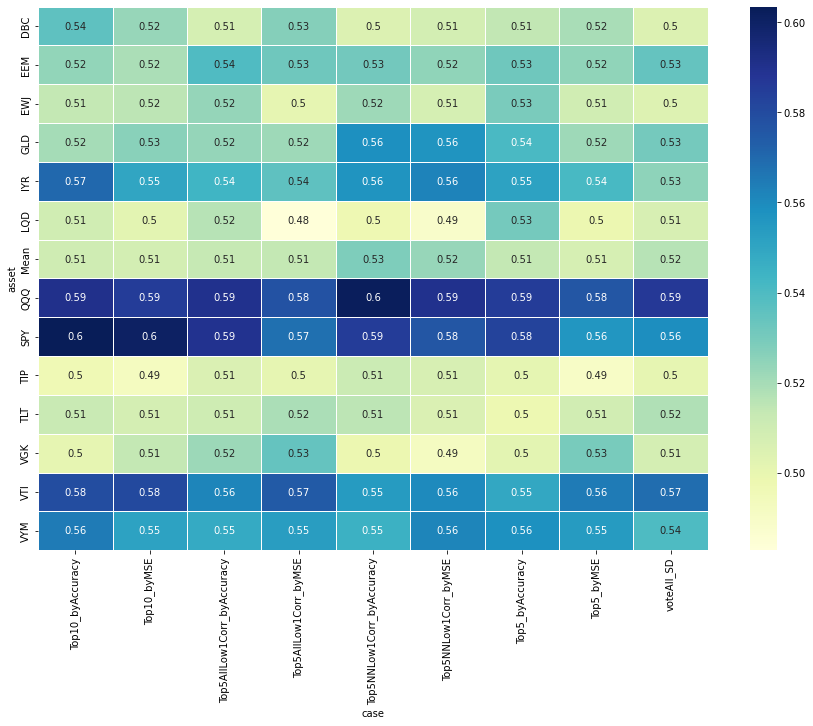

In [19]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(pt, cmap="YlGnBu", annot=True, linewidths=.5, ax=ax)

In [9]:
daily_res_df.loc[daily_res_df.index.get_level_values(1) == 'Mean', :].sort_values('f0_score', ascending=False)

,,accuracy,precision,recall,recall0,f1_score,f0_score,MSE,MSE_fullscore,MSE_byProba,MSE_fullscore_byReturn
Top5_byAccuracy,Mean,0.513518,0.529366,0.674063,0.331968,0.592803,0.391208,1.237703,0.519972,1.119612,1.218853
Top5NNLow1Corr_byAccuracy,Mean,0.528216,0.539523,0.712899,0.320797,0.614171,0.390755,1.219394,0.519972,1.089424,1.218853
voteAll_SD,Mean,0.516422,0.531929,0.682634,0.328540,0.597719,0.389278,1.232237,0.519972,1.095049,1.218853
Top5_byMSE,Mean,0.506986,0.525543,0.661748,0.332136,0.585653,0.387465,1.261041,0.519972,1.126130,1.218853
Top5NNLow1Corr_byMSE,Mean,0.523226,0.535545,0.711102,0.312236,0.610953,0.382320,1.227031,0.519972,1.092432,1.218853
Top5AllLow1Corr_byMSE,Mean,0.513791,0.529808,0.692439,0.312617,0.600148,0.376272,1.242178,0.519972,1.099394,1.218853
Top5AllLow1Corr_byAccuracy,Mean,0.513246,0.528827,0.700626,0.302016,0.602332,0.367052,1.231093,0.519972,1.093791,1.218853
Top10_byAccuracy,Mean,0.509799,0.526050,0.705129,0.289598,0.602392,0.356283,1.242209,0.519972,1.085478,1.218853
Top10_byMSE,Mean,0.508710,0.524761,0.713605,0.278128,0.604723,0.347433,1.242935,0.519972,1.090879,1.218853


In [9]:
monthly_proba_df = proba_df.copy()
monthly_proba_df.index = monthly_proba_df.index.to_period("M")
monthly_proba_df = monthly_proba_df.groupby(monthly_proba_df.index).nth(-1)
monthly_proba_df

Top10All_byAccuracy_MPT                                          \
Symbol                         DBC  EEM  EWJ  GLD  IYR  LQD  QQQ  SPY  TIP   
Train Date                                                                   
2007-12                        0.5  0.5  0.7  0.7  0.5  0.7  0.9  1.0  0.5   
2008-01                        0.5  0.5  0.7  0.6  0.6  1.0  0.5  0.9  0.4   
2008-02                        0.5  0.8  0.5  0.7  0.6  0.7  0.3  0.9  0.5   
2008-03                        0.9  0.7  0.6  0.5  0.4  0.5  0.5  0.9  0.7   
2008-04                        0.6  0.4  0.8  0.5  0.6  0.5  0.3  0.4  0.8   
...                            ...  ...  ...  ...  ...  ...  ...  ...  ...   
2021-11                        0.7  0.9  0.9  0.9  0.8  0.7  1.0  1.0  0.9   
2021-12                        0.5  0.5  0.5  0.6  0.8  0.5  0.8  1.0  0.8   
2022-01                        0.5  0.5  0.5  0.9  0.8  0.7  0.8  0.8  0.9   
2022-02                        0.6  0.6  0.4  0.9  0.3  0.6  0.8  0.8  0.7   
2022-03                        0.6  0.6  0.3  0.8  0.3  0.6  0.8  0.8  0.7   

                 ... VoteAll_MPT                                          \
Symbol      TLT  ...         GLD       IYR       LQD       QQQ       SPY   
Train Date       ...                                                       
2007-12     0.6  ...    0.391304  0.739130  0.521739  0.739130  0.956522   
2008-01     0.8  ...    0.304348  0.739130  0.695652  0.739130  0.956522   
2008-02     0.4  ...    0.347826  0.608696  0.521739  0.652174  0.956522   
2008-03     0.6  ...    0.260870  0.695652  0.521739  0.652174  0.956522   
2008-04     0.6  ...    0.217391  0.826087  0.565217  0.608696  0.739130   
...         ...  ...         ...       ...       ...       ...       ...   
2021-11     0.6  ...    0.782609  0.695652  0.608696  0.652174  0.782609   
2021-12     0.4  ...    0.826087  0.608696  0.782609  0.826087  0.826087   
2022-01     0.5  ...    0.782609  0.434783  0.826087  0.869565  0.782609   
2022-02     0.2  ...    0.695652  0.434783  0.782609  0.913043  0.826087   
2022-03     0.2  ...    0.608696  0.434783  0.826087  0.913043  0.826087   

                                                              
Symbol           TIP       TLT       VGK       VTI       VYM  
Train Date                                                    
2007-12     0.217391  0.478261  0.739130  0.869565  0.130435  
2008-01     0.217391  0.826087  0.608696  0.869565  0.130435  
2008-02     0.217391  0.652174  0.739130  0.739130  0.130435  
2008-03     0.434783  0.608696  0.652174  0.782609  0.130435  
2008-04     0.478261  0.695652  0.695652  0.695652  0.217391  
...              ...       ...       ...       ...       ...  
2021-11     0.826087  0.608696  0.739130  0.826087  0.869565  
2021-12     0.739130  0.478261  0.565217  0.739130  0.347826  
2022-01     0.913043  0.608696  0.695652  0.739130  0.478261  
2022-02     0.869565  0.565217  0.695652  0.782609  0.478261  
2022-03     0.869565  0.608696  0.695652  0.782609  0.478261  

[172 rows x 312 columns]

In [10]:
monthly_res_dict = {}
for c in list(set(monthly_proba_df.columns.get_level_values(0))):
    # print("======================================================================  ", c)
    y_proba = monthly_proba_df[c]
    mse_ser, mseProba_ser, msefullscore_ser, msefullscore_ret_ser, prec_ser, acccc_ser, recall_ser, recall0_ser, f1score_ser, f0score_ser = cal_metric(monthly_y_pctch_21D, y_proba)
#     monthly_res_dict[c] = pd.concat([msefullscore_ser, mse_ser, msefullscore_ret_ser, mseProba_ser, prec_ser, acccc_ser], axis=1)
# monthly_res_df = pd.concat(monthly_res_dict.values(), keys=monthly_res_dict.keys(), axis=1)
# monthly_res_df = pd.concat([monthly_res_df, monthly_res_df.mean().to_frame(name='Mean').T])

    summary_df = pd.concat([acccc_ser, prec_ser, recall_ser, recall0_ser, f1score_ser, f0score_ser, mse_ser, msefullscore_ser, mseProba_ser, msefullscore_ret_ser], axis=1)
    if pp == 10:
        summary_df = pd.concat([summary_df, summary_df.loc[vote_3asset, :].mean().to_frame(name='Mean').T])
    else:
        summary_df = pd.concat([summary_df, summary_df.mean().to_frame(name='Mean').T])
    monthly_res_dict[c] = summary_df
monthly_res_df = pd.concat(monthly_res_dict.values(), keys=monthly_res_dict.keys(), axis=0)

In [35]:
monthly_res_df

accuracy  precision    recall   recall0  f1_score  \
Top5NNLow1Corr DBC   0.564972   0.585586  0.677083  0.432099  0.628019   
               EEM   0.576271   0.578571  0.835052  0.262500  0.683544   
               EWJ   0.474576   0.514925  0.711340  0.187500  0.597403   
               GLD   0.564972   0.569231  0.778947  0.317073  0.657778   
               IYR   0.519774   0.582524  0.588235  0.426667  0.585366   
               LQD   0.395480   0.346774  0.623188  0.250000  0.445596   
               QQQ   0.581921   0.620690  0.825688  0.191176  0.708661   
               SPY   0.553672   0.590604  0.830189  0.140845  0.690196   
               TIP   0.468927   0.426357  0.733333  0.274510  0.539216   
               TLT   0.531073   0.427273  0.701493  0.427273  0.531073   
               VGK   0.480226   0.528455  0.656566  0.256410  0.585586   
               VTI   0.525424   0.583333  0.777778  0.130435  0.666667   
               VYM   0.598870   0.685714  0.654545  0.507463  0.669767   
               Mean  0.525858   0.541541  0.722572  0.292612  0.614529   
voteAll_SD     DBC   0.531073   0.557522  0.656250  0.382716  0.602871   
               EEM   0.553672   0.573770  0.721649  0.350000  0.639269   
               EWJ   0.480226   0.521008  0.639175  0.287500  0.574074   
               GLD   0.514124   0.536000  0.705263  0.292683  0.609091   
               IYR   0.485876   0.549550  0.598039  0.333333  0.572770   
               LQD   0.418079   0.355932  0.608696  0.296296  0.449198   
               QQQ   0.576271   0.623188  0.788991  0.235294  0.696356   
               SPY   0.542373   0.592593  0.754717  0.225352  0.663900   
               TIP   0.474576   0.425000  0.680000  0.323529  0.523077   
               TLT   0.491525   0.398230  0.671642  0.381818  0.500000   
               VGK   0.531073   0.572727  0.636364  0.397436  0.602871   
               VTI   0.525424   0.593750  0.703704  0.246377  0.644068   
               VYM   0.598870   0.663866  0.718182  0.402985  0.689956   
               Mean  0.517166   0.535626  0.683282  0.319640  0.597500   

                     f0_score       MSE  MSE_fullscore  MSE_byProba  \
Top5NNLow1Corr DBC   0.476190  1.191694       0.499682     1.088459   
               EEM   0.358974  1.230245       0.498253     1.110649   
               EWJ   0.243902  1.354630       0.526621     1.212614   
               GLD   0.403101  1.119230       0.479821     1.063596   
               IYR   0.429530  1.200082       0.595610     1.122413   
               LQD   0.335404  1.540907       0.604819     1.330271   
               QQQ   0.260000  1.152609       0.457076     1.093522   
               SPY   0.202020  1.274180       0.498045     1.152174   
               TIP   0.373333  1.355266       0.562989     1.259546   
               TLT   0.531073  1.168385       0.511556     1.077728   
               VGK   0.303030  1.303954       0.509229     1.176199   
               VTI   0.176471  1.276636       0.499007     1.209042   
               VYM   0.489209  1.121228       0.503301     0.989516   
               Mean  0.352480  1.253004       0.518924     1.145056   
voteAll_SD     DBC   0.427586  1.184412       0.499682     1.046172   
               EEM   0.414815  1.223903       0.498253     1.020691   
               EWJ   0.333333  1.282415       0.526621     1.107203   
               GLD   0.358209  1.218732       0.479821     1.073407   
               IYR   0.354610  1.357233       0.595610     1.152254   
               LQD   0.383234  1.385870       0.604819     1.233572   
               QQQ   0.299065  1.193901       0.457076     1.119641   
               SPY   0.283186  1.296668       0.498045     1.179453   
               TIP   0.415094  1.312864       0.562989     1.189229   
               TLT   0.482759  1.206124       0.511556     1.089690   
               VGK   0.427586  1.165750       0.509229     1.058235   
               VTI   0.28813

In [11]:
monthly_res_df.loc[monthly_res_df.index.get_level_values(1) == 'Mean', :].sort_values('recall0', ascending=False)

,,accuracy,precision,recall,recall0,f1_score,f0_score,MSE,MSE_fullscore,MSE_byProba,MSE_fullscore_byReturn
VoteAll_bySD,Mean,0.525492,0.567456,0.641216,0.360598,0.599916,0.390013,1.254334,0.534714,1.101570,1.173695
Top5VoteAll_byCV_MPT,Mean,0.554562,0.580692,0.692025,0.343772,0.629571,0.382824,1.185667,0.534714,1.071195,1.173695
Top10VoteAll_byCV_MPT,Mean,0.561270,0.581866,0.728124,0.309979,0.644556,0.359971,1.189644,0.534714,1.058253,1.173695
trans_preds_Top5NNLow1_byMSE,Mean,0.519231,0.561594,0.687053,0.296620,0.612754,0.334952,1.267344,0.534714,1.139701,1.173695
Top5AllLow1_byMSE_MPT,Mean,0.557245,0.579076,0.737854,0.295186,0.647103,0.351418,1.184795,0.534714,1.044098,1.173695
trans_preds_voteEnsemble(Top5NNLow1_byAccuracy_MPT+VoteAll_bySD+Top5NNLow1_byMSE_MPT),Mean,0.533542,0.564634,0.707865,0.285204,0.624283,0.328789,1.251530,0.534714,1.101907,1.173695
Top5AllLow1_byAccuracy_MPT,Mean,0.562612,0.579477,0.762825,0.270922,0.657025,0.329883,1.187643,0.534714,1.050945,1.173695
trans_preds_Top5NNLow1_by1-div-STD_accuracy-div-MSE,Mean,0.526386,0.558981,0.711808,0.266086,0.621433,0.308377,1.262443,0.534714,1.133161,1.173695
trans_preds_voteEnsemble(Top5NNLow1_byAccuracy_MPT+Top5NNLow1_byMSE_MPT),Mean,0.526386,0.558155,0.717376,0.256896,0.623574,0.299862,1.267478,0.534714,1.128499,1.173695
Top5NNLow1_byMSE_MPT,Mean,0.525492,0.557854,0.718031,0.255165,0.623515,0.298150,1.266971,0.534714,1.133519,1.173695


In [18]:
save_folder = preds_folder
# monthly_res_df.to_csv(os.path.join(save_folder, 'ML_preformance(monthly).csv'))
daily_res_df.to_csv(os.path.join(save_folder, 'ML_preformance(daily).csv'))